# User and Item Based Filtering
> Two different ways to do collaborative filtering

- toc: true 
- badges: true
- comments: true
- search_exclude: false
- categories: [machinelearning]

Collaborative Filtering is a method in recommendation systems that searches for similar objects in order to create a ranked list of suggestions. In general, we distinguish between two different approaches:

- User-based filtering: we first identify the most similar users to the one for whom we want to give recommendations.
- Item-based filtering: we first search for the most similar items to the ones that are most relevant to the user (e.g., most liked by the user)

We will look at both approaches and discuss their advantages. This blog post is very much inspired by Chapter 2 of Toby Segaran's classic book "Programming Collective Intelligence" (O'Reilly, 2007).

## Data

For our discussion we need some recommendation data. There are several ways of expressing a user's preference, such as binary distinctions (booked a hotel vs. didn't book the hotel) or more explicit feedback in the form of graded reviews.

We take the exemplary data below (taken from Segaran's book) and compute the recommendations using the Pandas library. 

In [2]:
critics={'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
      'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5,
      'The Night Listener': 3.0},
     'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5,
      'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0,
      'You, Me and Dupree': 3.5},
     'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
      'Superman Returns': 3.5, 'The Night Listener': 4.0},
     'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
      'The Night Listener': 4.5, 'Superman Returns': 4.0,
      'You, Me and Dupree': 2.5},
     'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
      'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
      'You, Me and Dupree': 2.0},
     'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
      'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
     'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}
}

In [3]:
import pandas as pd
critics = pd.DataFrame(critics).T

In [4]:
critics

,Lady in the Water,Snakes on a Plane,Just My Luck,Superman Returns,"You, Me and Dupree",The Night Listener
Lisa Rose,2.5,3.5,3.0,3.5,2.5,3.0
Gene Seymour,3.0,3.5,1.5,5.0,3.5,3.0
Michael Phillips,2.5,3.0,NaN,3.5,NaN,4.0
Claudia Puig,NaN,3.5,3.0,4.0,2.5,4.5
Mick LaSalle,3.0,4.0,2.0,3.0,2.0,3.0
Jack Matthews,3.0,4.0,NaN,5.0,3.5,3.0
Toby,NaN,4.5,NaN,4.0,1.0,NaN


The data frame shows our toy data set as an input for recommendations. Usually, the matrix is much bigger and way more sparse. Yet, it illustrates the fact that some users (such as Toby) haven't rated (and thus might not have seen) all the movies. We would like to get a ranking of the missing movies so that we can recommend the movie which most likely fits to their preferences.

In the collaborative filtering approach (be it user or item based), there are the two main steps to get to this ranking (here illustrated with the user-based approach for our movie toy data set):

1. Define a similarity between objects (either users or items). This step is different from user and item based recommenders and gives them their respective names. In the user-based approach, the similarity is defined in terms of how the users rated the movies. If users give the same or a very similar rating to the same movie, they are considered more similar than if they give very different ratings. We will see below how we can quantify this to arrive at a similarity matrix between users.
2. The second step takes the previously defined similarity metric and uses it to compute a weighted average to obtain the final recommendation scores. Once we identified a similarity among users, we will check all the missing movies and weigh the ratings that the other users gave depending on their similarity to the user at hand. 

# User-based Filtering

Now we want to go through the different steps for user-based filtering and compute the similarities and rankings. 

## Step 1: Identify similar users

There are multiple ways to define the similarity among users based on the ratings they gave to the movies. However, there is one particular method that is easy to understand and visualize: the **Euclidean Distance** score.

For the sake of simplicity, let's reduce the number of movies in our dataset to two: 

1. Snakes on a Plane
1. You, Me and Dupree

The ratings for the two movies constitute the features on which the users can be compared. A two-dimenstional visualization would look like this:

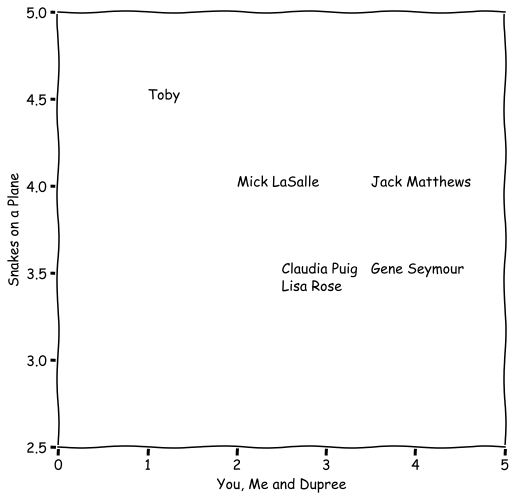

In [16]:
# Euclidean distance example
import matplotlib.pyplot as plt
import numpy as np

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(8,8))
    xaxis = 'You, Me and Dupree'
    yaxis = 'Snakes on a Plane'
    critics[[xaxis, yaxis]].plot(kind='scatter', x=xaxis, y=yaxis, ax=ax, xlim=(0,5), ylim=(2.5,5), alpha=0);

    # annotate the labels

    for label in critics.index.values:
      xval, yval = critics.loc[label, [xaxis, yaxis]]
      if label == 'Lisa Rose': # make sure that labels don't overlap
            yval -= 0.1
      ax.annotate(label, (xval, yval))

As you can see, Claudia Puig and Lisa Rose are pretty close to each other (actually, they overlap as they have exactly the same values for both features) while Toby and Gene Seymour are most dissimilar. Although the two-dimensional plot nicely shows the differences between users for these two movies, there are two problems:

1. there are more than two movies, hence we need a higher dimensional plot (which would be hard to visualize)
1. it is hard to compare all the users to each other; it would be preferable to have a single (similarity or distance) score.

To this end, we compute the Euclidean distance score. It is best explained in the two-dimensional case above, however, it can easily be extended to higher dimensional cases. As we all learned in high-school geometry, you can compute the distance of two points in a two-dimensional space if you compute the following steps:

1. compute the distance between the points on each axis and square it
1. take the sum of the distances from all axes
1. take the square root of the total sum

Since this defines a distance function, yet we need a similarity score we just use the Euclidean score, add 1 to it (so not to run into any division-by-zero error) and invert it. The final function looks as follows. Note that we didn't take the square root (to get the same results as in Segaran's book). The square root doesn't change anything in the order of the similarities/distances and thus can be ignored for our purposes.

In [17]:
import numpy as np

def euclidean(a, b):
  eucl = np.square(a-b).sum()
  return 1/(1+eucl)

In Pandas, there is a very convenient way to get the pairwise results for a function like the `euclidean()` above for a data frame by using the `corr()` method and specify your own method (in this case just giving the function name `euclidean` as the parameter `method`). You just have to decide for which items in our data frame the correlation 
should be computed, for the users or the movies. In our case, we're interested in the users, that's why 
we have to transpose the data frame first (by using the `.T` shortcut, i.e., `critics.T`) before applying the correlation method.

In [19]:
critics.T.corr(method=euclidean)

,Lisa Rose,Gene Seymour,Michael Phillips,Claudia Puig,Mick LaSalle,Jack Matthews,Toby
Lisa Rose,1.000000,0.148148,0.444444,0.285714,0.333333,0.210526,0.222222
Gene Seymour,0.148148,1.000000,0.210526,0.133333,0.129032,0.800000,0.108108
Michael Phillips,0.444444,0.210526,1.000000,0.571429,0.285714,0.181818,0.285714
Claudia Puig,0.285714,0.133333,0.571429,1.000000,0.173913,0.181818,0.235294
Mick LaSalle,0.333333,0.129032,0.285714,0.173913,1.000000,0.137931,0.307692
Jack Matthews,0.210526,0.800000,0.181818,0.181818,0.137931,1.000000,0.117647
Toby,0.222222,0.108108,0.285714,0.235294,0.307692,0.117647,1.000000


As can be seen in the resulting matrix, some users are more similar to each other than others. For example, users Gene Seymour and Jack Matthews are pretty close to each other (0.8). In fact, except for "Snakes on a Plane" they gave the exact same ratings to all movies that they both watched. 

On the other hand, users Gene Seymour and Toby are most dissimilar (with a distance score of 0.108). This is due to the fact that they have only three movies that they both gave ratings to and those three movies have comparatively big differences.

In [21]:
critics.loc[['Jack Matthews', 'Gene Seymour', 'Toby']]

,Lady in the Water,Snakes on a Plane,Just My Luck,Superman Returns,"You, Me and Dupree",The Night Listener
Jack Matthews,3.0,4.0,NaN,5.0,3.5,3.0
Gene Seymour,3.0,3.5,1.5,5.0,3.5,3.0
Toby,NaN,4.5,NaN,4.0,1.0,NaN


## Ranking the critics

With the Euclidean similarity matrix we can compute a ranking of critics for each user. To this end, we define the function `top_matches` that makes use of the `corr()` method of data frames for the similary scores. To get a proper similarity ranking, we first identify all users other than the one under investigation and return a Pandas Series that is created by indexing the similarity matrix for the respective user. Finally, the series is sorted in reverse order to return the top similar users.

In [22]:
def top_matches(critics, person, n=10, method=euclidean):
  other_people = [p for p in critics.T.columns if p != person]
  corr_persons = critics.T.corr(method=method)
  scores = corr_persons.loc[other_people, person]
  scores.sort_values(ascending=False, inplace=True)
  return scores.head(n)


The most similar user to Toby is Mick LaSalle, showing a similarity value of 0.307, whereas the least similar is Gene Seymour (as discussed above).

In [24]:
top_matches(critics, 'Toby')

Mick LaSalle        0.307692
Michael Phillips    0.285714
Claudia Puig        0.235294
Lisa Rose           0.222222
Jack Matthews       0.117647
Gene Seymour        0.108108
Name: Toby, dtype: float64

## Step 2: Recommending Items

Having defined the similarity of users, we can move to the second step: how to compute the actual recommendations for user Toby. For this, we first select those movies in our toy dataset that Toby hasn't ranked yet (assuming he hasn't watched them either). These missing movies are the basis for our recommendations. All we need to do now is rank them in the appropriate order so that the movie that we assume he would rate highest comes up first in our ranking.

This begs the question how we make the predictions. The basic idea is pretty simple: we take the ratings from other users for the missing movies and compute the weighted average of the rankings for each movie. But where do we take the weights from? It's very easy. We take advantage of the similarities that we worked out above. Thus, the final score for each movie (for user Toby) is calculated by taking the sum of the rating times the similarity (to Toby) for each movie divided by the overall sum of the similarities.

$ score_{movie} = \frac{\sum_{i=1}^{users} sim_{user_i, Toby} * rating_{user_i, movie}}{\sum_{i=1}^{users} sim_{user_i, Toby}}$

In Pandas, we can use the `isnull()` method on the Series to identify all the missing movies for the user. We then index into the ratings data frame, extracting only those cells with similar users and missing films. For the actual computation of the scores we need two objects: 

1. the subset of the cells from the original data frame of ratings giving the similar users and the missing movies (`cores`)
2. the filtered user similarities where all negatively correlated users to Toby have been discarded (`sims`)

In [25]:
def get_recommendations(critics, person):
  missing_films = critics.T[critics.T[person].isnull()].index.values
  person_similarities = top_matches(critics, person, n=len(critics))
  person_similarities = person_similarities[person_similarities > 0]
  movies_scores = critics.loc[person_similarities.index, missing_films]
  return movies_scores, person_similarities

In [26]:
scores, sims = get_recommendations(critics, 'Toby')
scores

,Lady in the Water,Just My Luck,The Night Listener
Mick LaSalle,3.0,2.0,3.0
Michael Phillips,2.5,NaN,4.0
Claudia Puig,NaN,3.0,4.5
Lisa Rose,2.5,3.0,3.0
Jack Matthews,3.0,NaN,3.0
Gene Seymour,3.0,1.5,3.0


In [27]:
sims

Mick LaSalle        0.307692
Michael Phillips    0.285714
Claudia Puig        0.235294
Lisa Rose           0.222222
Jack Matthews       0.117647
Gene Seymour        0.108108
Name: Toby, dtype: float64

With these two objects we can first compute the numerator of the final score by taking the ratings for the missing movies and multiply them by the respective user's similarity to Toby.

In [28]:
films_overview = scores.T * sims
films_overview

,Mick LaSalle,Michael Phillips,Claudia Puig,Lisa Rose,Jack Matthews,Gene Seymour
Lady in the Water,0.923077,0.714286,NaN,0.555556,0.352941,0.324324
Just My Luck,0.615385,NaN,0.705882,0.666667,NaN,0.162162
The Night Listener,0.923077,1.142857,1.058824,0.666667,0.352941,0.324324


After that, we can easily get the sum of these weighted scores for each movie.

In [29]:
films_overview.sum(axis=1)

Lady in the Water     2.870184
Just My Luck          2.150096
The Night Listener    4.468690
dtype: float64

All that is left now is to compute the denominator. For this, we take the non-null ratings as a mask for the similarities. The reason for this step is to remove individual similarities from the totals if the user didn't rate the respective movie. Pandas's weak typing comes in handy at this step. The boolean return values of the `notnull()` method are turned into integers (0 for `False`), which nullify the factor for the respective user. At the end, we obtain a similarity total for each movie.

In [30]:
totals = (scores.notnull().T * sims).sum(axis=1)
totals

Lady in the Water     1.041384
Just My Luck          0.873317
The Night Listener    1.276678
dtype: float64

Finally, we can compute the actual predicted movie ratings for user Toby by taking the sums of the weighted scores and dividing them by the totals. In our toy example, the movie 'The Night Listener' gets the highest rating with 3.35 and would thus be our first choice for a recommendation to Toby.

In [31]:
recs = films_overview.sum(axis=1) / totals
recs.sort_values()

Just My Luck          2.461988
Lady in the Water     2.756124
The Night Listener    3.500248
dtype: float64

# Item-based Filtering

So far, we've looked at the user similarities first to reduce the search space for our recommendations. However, this comes with a downside when your matrix of ratings includes a large number of users and shows a lot of sparsity, thus making it hard to compute similarities among users when there is little to no overlap.

An alternative approach, called item-based filtering, tries to remedy these problems by dispensing with the user similarity step and searching for similar items right away (hence the name). With our toy dataframe this is very easy as we only need to apply the `corr()` method again, this time on the items and not on the users:

In [32]:
critics.corr(method=euclidean)

,Lady in the Water,Snakes on a Plane,Just My Luck,Superman Returns,"You, Me and Dupree",The Night Listener
Lady in the Water,1.000000,0.222222,0.222222,0.090909,0.400000,0.285714
Snakes on a Plane,0.222222,1.000000,0.105263,0.166667,0.051282,0.181818
Just My Luck,0.222222,0.105263,1.000000,0.064516,0.181818,0.153846
Superman Returns,0.090909,0.166667,0.064516,1.000000,0.053333,0.102564
"You, Me and Dupree",0.400000,0.051282,0.181818,0.053333,1.000000,0.148148
The Night Listener,0.285714,0.181818,0.153846,0.102564,0.148148,1.000000


Again, the same principles apply that we mentioned above for the user similarities. A score close to 1 indicates that the movies are very similar. For example, the movies 'Snakes on a Plane' and 'Lady in the Water' seem to be alike based on the users's ratings whereas 'Just my Luck' and 'Lady in the Water' are quite dissimilar. 

To compute the final recommendation scores all we need to do is to identify the missing movies of a given user (Toby) and compute a weighted average of their similarity to all movies the user has already rated together with their similarity to the missing movies.

In [33]:
def get_item_recommendations(critics, person, method='pearson'):
  missing_films = critics.T[critics.T[person].isnull()].index.values
  movie_similarities = critics.corr(method=method)
  movie_similarities = movie_similarities.loc[~movie_similarities.index.isin(missing_films), missing_films]
  person_ratings = critics.loc[person, ~critics.columns.isin(missing_films)]
  
  return movie_similarities, person_ratings

In [34]:
ms, pr = get_item_recommendations(critics, 'Toby', method=euclidean)
ms

,Lady in the Water,Just My Luck,The Night Listener
Snakes on a Plane,0.222222,0.105263,0.181818
Superman Returns,0.090909,0.064516,0.102564
"You, Me and Dupree",0.400000,0.181818,0.148148


In [35]:
pr

Snakes on a Plane     4.5
Superman Returns      4.0
You, Me and Dupree    1.0
Name: Toby, dtype: float64

Like above, we now take the missing movies and weigh them with the similarities that we defined above. The result is an item-based recommendation score that indicates which movies we should recommend next to the user (in this case Toby).

In [36]:
(ms.T * pr).sum(axis=1)

Lady in the Water     1.763636
Just My Luck          0.913567
The Night Listener    1.376586
dtype: float64

In [37]:
item_recos = (ms.T*pr).sum(axis=1) / ms.sum()
item_recos

Lady in the Water     2.473088
Just My Luck          2.598332
The Night Listener    3.182635
dtype: float64

# User or Item-based Filtering?

As shown above, user and item-based filtering mainly differ in the first step: we either have to compute similarities for users or times first. With a very large database, item-based filtering is to be preferred as it is significantly faster to compare the items for users to identify the similarities than to compare a given user to all other users